# Group-Specific Discriminant Analysis for sex-specific lateralization Running Demo

[Open in Colab](https://colab.research.google.com/github/shuo-zhou/GSDA-Lateralization/blob/clean-code/gsda_demo.ipynb)  (click `Runtime` → `Run all (Ctrl+F9)`)

<!-- [Open in Colab](https://colab.research.google.com/github/shuo-zhou/GSDA-Lateralization/blob/main/gsda_demo.ipynb)  (click `Runtime` → `Run all (Ctrl+F9)`) -->

## Setup

The first few blocks of code are necessary to set up the notebook execution environment. This checks if the notebook is running on Google Colab and installs required packages.


In [ ]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !pip uninstall --yes yellowbrick
    !pip install -U -q psutil
    !pip install dgl dgllife
    !pip install rdkit-pypi
    !pip install PrettyTable yacs
    !git clone https://github.com/shuo-zhou/GSDA-Lateralization
    %cd GSDA-Lateralization
else:
    print('Not running on CoLab')
     

## Import required modules

In [ ]:
import os
from configs.default_cfg import get_cfg_defaults
from utils.experiment import run_experiment
from joblib import Parallel, delayed

from utils.io_ import load_result, reformat_results
from utils import plot

## Configurations

The customized configuration used in this demo is stored in `configs/gsda_demo.yaml`, this file overwrites defaults in `default_cfg.py` where a value is specified.

In [ ]:
# ---- setup configs ----
cfg_path = "configs/hcp_demo.yaml" # Path to `.yaml` config file

cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_path)
cfg.freeze()
print(cfg)

DATASET:
  ATLAS: BNA
  CONNECTION: intra
  DATASET: HCP
  DOWNLOAD: True
  FEATURE: correlation
  MIX_GROUP: False
  NUM_REPEAT: 1
  REST1_ONLY: False
  ROOT: data
  RUN: Fisherz
  SESSIONS: [None]
  TEST_RATIO: 0.2
  TYPE: functional
OUTPUT:
  ROOT: output
SOLVER:
  L2_HPARAM: 0.1
  LAMBDA_: [0.0, 2.0, 5.0, 8.0, 10]
  LR: 1.0
  MAX_ITER: 100
  OPTIMIZER: lbfgs
  SEED: 2023


## Model training

It could take a while (15 to 25 mins) to run the experiments. 

In [ ]:
Parallel(n_jobs=2)(delayed(run_experiment)(cfg, lambda_) for lambda_ in cfg.SOLVER.LAMBDA_)
# run_experiment(cfg)

Training model with lambda = 0.0 on HCP dataset
Training model with lambda = 2.0 on HCP dataset
Training model with lambda = 5.0 on HCP dataset
Training model with lambda = 10 on HCP dataset


[None, None, None, None]

## Load and visualize results 

In [ ]:
dataset = cfg.DATASET.DATASET
model_root_dir = cfg.OUTPUT.ROOT
lambdas = cfg.SOLVER.LAMBDA_
seed_start = cfg.SOLVER.SEED
test_size = cfg.DATASET.TEST_RATIO

res_df = load_result(dataset=dataset, root_dir=model_root_dir, 
                         lambdas=lambdas, seed_start=seed_start, test_size=test_size)

res_df["GSI_train_session"] = 2 * (res_df["acc_tgt_train_session"] * 
                                       (res_df["acc_tgt_train_session"] - 
                                        res_df["acc_nt_train_session"]))
res_df["GSI_test_session"] = 2 * (res_df["acc_tgt_test_session"] * 
                                      (res_df["acc_tgt_test_session"] - 
                                       res_df["acc_nt_test_session"]))

res_df_train_session = reformat_results(res_df, ["acc_tgt_train_session", "acc_nt_train_session"])
res_df_test_session = reformat_results(res_df, ["acc_tgt_test_session", "acc_nt_test_session"])

res_df.loc[res_df["train_group" ]==0, "train_group" ] = "Male"
res_df.loc[res_df["train_group" ]==1, "train_group" ] = "Female"

<Figure size 640x480 with 0 Axes>

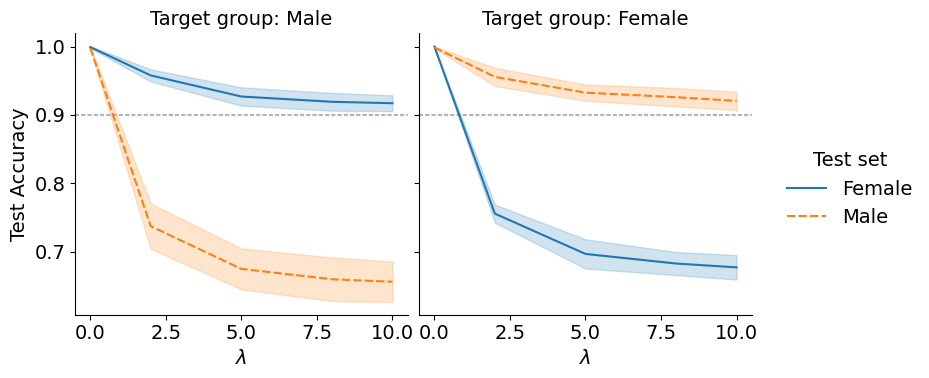

In [ ]:
if not os.path.exists("figures"):
    os.mkdir("figures")
plot.plot_accuracy(res_df_train_session)

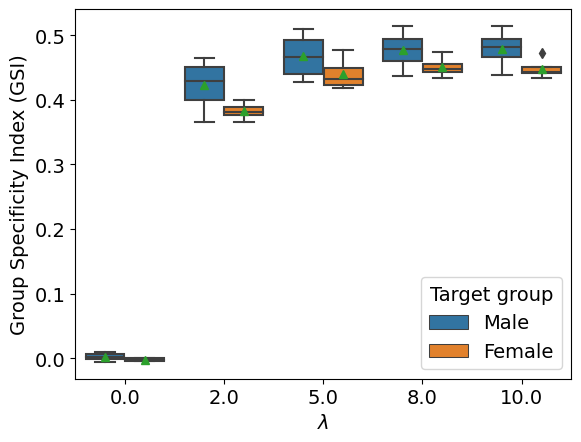

In [ ]:
plot.plot_gsi(res_df, x="lambda", y="GSI_train_session", hue="train_group")